In [22]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

caldatafile = r'C:\Localdata\D\Note\Python\apps\MXP\ContourSelect\samplejob\\h/cache/dummydb/result/MXP/job1\ContourSelectModelCalibration430result1\caldata.txt'

df = pd.read_csv(caldatafile, sep='\s+')
tgtColName = 'UserLabel'

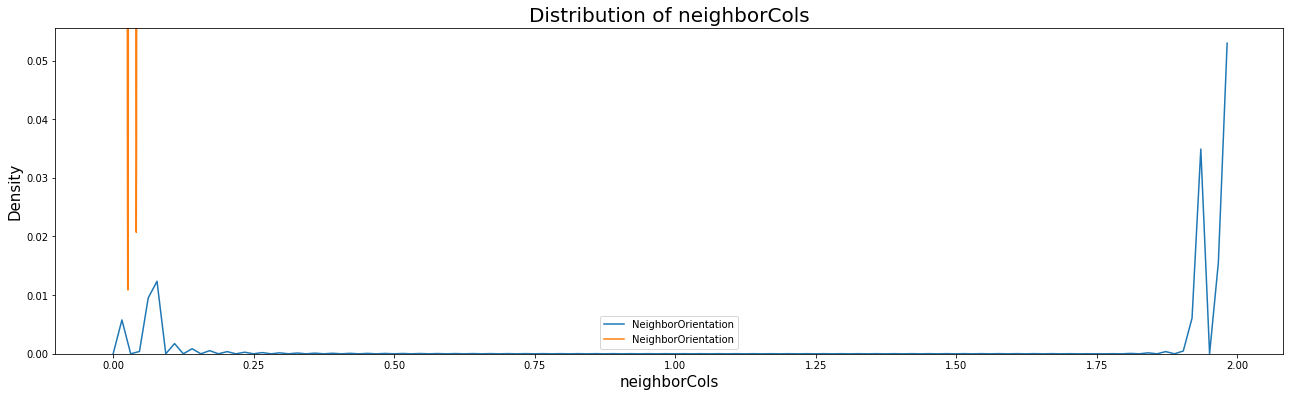

In [24]:
fig = plt.figure(figsize=(22,6))
neighborColNames = ['NeighborOrientation']#, 'NeighborParalism']
for curcol in neighborColNames:
    sns.kdeplot(df.loc[df[tgtColName] == 1, curcol])
    sns.kdeplot(df.loc[df[tgtColName] == 0, curcol])
plt.xlabel('neighborCols',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of neighborCols',fontsize=20);
plt.show()

In [ ]:
df[df.NeighborOrientation>2, :